In [1]:
def generate_grid_edges(grid_size):
    if grid_size < 1:
        return []

    grid_edges = []
    node_count = grid_size * grid_size

    for i in range(grid_size):
        for j in range(grid_size):
            node = i * grid_size + j

            # Right neighbor
            if j < grid_size - 1:
                right_neighbor = i * grid_size + (j + 1)
                grid_edges.append((node, right_neighbor))

            # Bottom neighbor
            if i < grid_size - 1:
                bottom_neighbor = (i + 1) * grid_size + j
                grid_edges.append((node, bottom_neighbor))

    return grid_edges


def add2direction(space_arc:list):
    new_space_arc = []
    for tup in space_arc:
        new_space_arc.append((tup[1],tup[0]))
    return space_arc+new_space_arc


grid_size = 3
edges = generate_grid_edges(grid_size)

print(edges)

[(0, 1), (0, 3), (1, 2), (1, 4), (2, 5), (3, 4), (3, 6), (4, 5), (4, 7), (5, 8), (6, 7), (7, 8)]


In [3]:
from collections import defaultdict
d = defaultdict(list)
d[(0,1)].append([0,1,2,3])

In [4]:
state = 0 if road else 1

point  node

road   arc

defaultdict(list, {(0, 1): [[0, 1, 2, 3]]})

In [2]:
from gurobipy import *

m = Model()
# space_arc will be constrained by geology or topology
# in the future, may set up subset G for every k: means set up subset space_arc for every k 
#          constrained by shortest time according to k vehicle

'''
# 3x3
space_arc = [
        (0,1),(0,3),(1,2),(1,4),(2,5),
        (3,4),(3,6),(4,5),(4,7),(5,8),
        (6,7),(7,8) ]
'''
space_arc =edges
space_arc_2 = add2direction(space_arc)

# 5x5
#space_arc = [
#        (0,1),(0,5),(1,2),(1,6),(2,3),(2,7),(3,4),(3,8),(4,9),
#        (5,6),(5,10),(6,7),(6,11),(7,8),(7,12),(8,9),(8,13),(9,14),
#        (10,11),(10,15),(11,12),(11,16),(12,13),(12,17),(13,14),(13,18),(14,19),
#        (15,20),(15,16),(16,21),(16,17),(17,18),(17,22),(18,19),(18,23),(19,24),
#        (20,21),(21,22),(22,23),(23,24) ]

'''
0   1   2   3   4
5   6   7   8   9
10  11  12  13  14
15  16  17  18  19
20  21  22  23  24
'''

# 3x3 test example
start = [(0,0),(91,0),(45,0),(24,0),(59,3),(20,1),(4,2),(56,3),(71,1),(82,5),(12,4),(19,2)]
dest = [11,7,12,28,19,42,51,10,99,60,82,2]


# 5x5 test example
#start = [(0,0),(2,1),(5,2),(11,3),(17,4),(23,5)]
#dest = [4,22,24,4,0,11]

#number_vehicle = 3
number_vehicle = 12

space_node = [i for i in range(grid_size*grid_size)] # grid_size
time_step = [i for i in range(2*grid_size*2)] # 2grid_size * t
# space_node = [i for i in range(25)] # 5x5
# time_step = [i for i in range(10)]


time_space_node = [(i,j) for i in space_node for j in time_step]  # (spcae, time)
#(t_s_node,t_s_node) constrained by time & space_arc
# (1)time: j[1] > i[1], if else the item should be (j,i)
# (2)space_arc :(i[0], j[0]) must be in space_arc 
# time_space_arc = [(i, j) for i in time_space_node for j in time_space_node if ((i != j) and ((i[0],j[0]) in space_arc or (j[0],i[0]) in space_arc) and (j[1] > i[1]))] 
# (3)transfer from 1dir to 2dir
time_space_arc = [(i, j) for i in time_space_node for j in time_space_node if ((i != j) and (i[0],j[0]) in space_arc_2 and (j[1] > i[1]))] 

'''
some assumes
(i,j) is time-space node means i to j, means j is later than i
i[0] != j[0] means no wait in the same location
qp is space node, two-way graph (p,q) == (q,p)
但是双向道路应该是有两条,即(p,q)&(q,p)应该是两条路,应该分开统计block
'''


Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-17


'\nsome assumes\n(i,j) is time-space node means i to j, means j is later than i\ni[0] != j[0] means no wait in the same location\nqp is space node, two-way graph (p,q) == (q,p)\n但是双向道路应该是有两条,即(p,q)&(q,p)应该是两条路,应该分开统计block\n'

In [3]:
# set x,y,z var
# set x with time space arc constrains which includes space constrains and time constrains
x = {}
for (i, j) in time_space_arc:
    for k in range(number_vehicle):
        x[i, j, k] = m.addVar(vtype=GRB.BINARY, name=f'x_{i}_{j}_{k}')


# setup Y & Z, start and des
Y = {}
for i in time_space_node:
    for k in range(number_vehicle):
        if i == start[k]:
            Y[i,k] = 1
        else:
            Y[i,k] = 0


Z = {}
for i in time_space_node:
    for k in range(number_vehicle):
        Z[i,k] = m.addVar(vtype=GRB.BINARY, name=f'detination_{i}_for_{k}')

In [4]:
# set block var
'''
如果是2dir,下面所有的space_arc也需要变为2
'''
delta = {}
for (p,q) in space_arc_2:
    for t in time_step:
        for k in range(number_vehicle):
            delta[p,q,t,k] = m.addVar(vtype=GRB.BINARY, name=f'has_vehicle_on_{p}{q}_for_{k}_at_{t}')
C = {}
for (p,q) in space_arc_2:
    for t in time_step:
        C[p,q,t] = m.addVar(vtype=GRB.INTEGER, name=f'numberofvehicle_on_{p}{q}_at_{t}')

b = {}
for (p,q) in space_arc_2:
    for t in time_step:
        b[p,q,t] = m.addVar(vtype=GRB.BINARY, name=f'if_block_on_{p}{q}_at_{t}')

bb = {}
for t in time_step:
    bb[t] = m.addVar(vtype=GRB.INTEGER, name=f'numberofblock_at_{t}')

B = m.addVar(vtype=GRB.INTEGER, name=f'block_number')

T = m.addVar(vtype=GRB.INTEGER, name=f'total_time')





In [5]:
# set other var
# middle var for block counting
f = {}
ff = {}
for (p,q) in space_arc_2:
    for t in time_step:
        f[p,q,t] = m.addVar(vtype=GRB.INTEGER, name=f'middle_on_{p}{q}_at_{t}')
        ff[p,q,t] = m.addVar(vtype=GRB.INTEGER, name=f'mmiddle_on_{p}{q}_at_{t}', lb=-GRB.INFINITY)

# corner block
r = {}
beta = {}
for i in time_space_node:
    r[i] = m.addVar(vtype=GRB.BINARY, name=f'block_at_{i}', lb=-GRB.INFINITY)
    beta[i] = m.addVar(vtype=GRB.INTEGER, name=f'number_of_vehicle_at_{i}', lb=-GRB.INFINITY)

R = m.addVar(vtype=GRB.INTEGER, name=f'total_coner_block')

# number of block between i & j
l = {}
for (i, j) in time_space_arc:
    l[i, j] = m.addVar(vtype=GRB.INTEGER, name=f'number_of_b_{i}&{j}')

# middle var for multi
z = {}
for (i, j) in time_space_arc:
    for k in range(number_vehicle):
        z[i, j, k] = m.addVar(vtype=GRB.INTEGER, name=f'z_{i}_{j}_{k}',lb=-GRB.INFINITY)

zz = {}
for (i, j) in time_space_arc:
    for k in range(number_vehicle):
        zz[i, j, k] = m.addVar(vtype=GRB.INTEGER, name=f'z_{i}_{j}_{k}',lb=-GRB.INFINITY)

m.update()

In [6]:
# constrains for block
# delta used to be binary represents whether k on pq at time t
# counterexample a to b from time 0 to 2. when it comes to time 0 to 1, the variable x will be 0, but delta should be 1
# 
'''
下面的space_arc应该都要变成2dir
'''
key_l = list(x.keys())
for (p,q) in space_arc_2:
    # select graph from pq
    for k in range(number_vehicle):
        # ts_pq_arc = [(i,j) for (i,j) in time_space_arc if ((i[0],j[0])==(p,q) or (i[0],j[0])==(q,p))]
        ts_pq_arc = [(i,j) for (i,j) in time_space_arc if (i[0],j[0])==(p,q)]

        for t in time_step:
            m.addConstr(delta[p,q,t,k] == quicksum(x[i,j,k] for (i,j) in ts_pq_arc if (i[1]<=t and t<=j[1] - 1))) # 如果不是j[1]-1就会出现01道路上，a车在时刻2从1出去，b车在时刻2从0进来，这种情况算堵车
            
        #for (i,j,k) in time_space_arc and i in G_pq_arc and j in G_pq_arc:
        #    m.addConstr(quicksum(delta[p,q,t,k] for t in range(i[1],j[1]+1)) == (j[1]-i[1]+1) * x[i,j,k])
                

for (p,q) in space_arc_2:
    for t in time_step:
        m.addConstr(C[p,q,t] == quicksum(delta[p,q,t,k] for k in range(number_vehicle)))


b0 = 1 # block threshold
M = 100
'''
for (p,q) in space_arc_2:
    for t in time_step:
        m.addConstr(b[p,q,t]*M >= C[p,q,t] - b0) 

# 上面大M法有一些松弛，对于b来说永远可以取1，有好处坏处，好处变为速度控制，坏处则不可控
# 下面用max min的方法对b夹逼一下，不给b松弛 需要引入新中间变量f
'''

'''
这地方不减阈值堵车的时候就算不出来
另外只能将变量常数传给max_ min_,因此gp.max_((C[p,q,t]+0), constant=0)) 写法是不行的,必须额外增加一个变量 
https://support.gurobi.com/hc/en-us/community/posts/360078185112-gurobipy-Model-addGenConstrMin-Invalid-data-in-vars-array
'''

''''''
for (p,q) in space_arc_2:
    for t in time_step:
        m.addConstr(ff[p,q,t] == C[p,q,t]-b0)
        m.addConstr(f[p,q,t] == max_(ff[p,q,t], constant=0)) 
        
        #m.addConstr(f[p,q,t] >= 0) 
        #m.addConstr(f[p,q,t] >= C[p,q,t] - 1)
        
        m.addConstr(b[p,q,t] == min_(f[p,q,t], constant=1))
        #m.addConstr(b[p,q,t] <= f[p,q,t]) # m.addConstr(b[p,q,t] == gp.min_(f[p,q,t], constant=1))
        #m.addConstr(b[p,q,t] <= 1)


# constrain for sum
for t in time_step:
    m.addConstr(quicksum(b[p,q,t] for (p,q) in space_arc_2) == bb[t])

# constrain for sum 
m.addConstr(B == quicksum(bb[t] for t in time_step))
# SPEED LIMIT


<gurobi.Constr *Awaiting Model Update*>

In [7]:
# constrains for time
tau = 1.5+0.01
for key in list(x.keys()):
    '''
    t_i = key[0][1]
    t_j = key[1][1]
    m.addConstr((t_j - t_i - 1) * x[key] <= 2)
    m.addConstr(t_j - t_i >= 2 * x[key])
    '''
    i = key[0]
    j = key[1]
    t_i = key[0][1]
    t_j = key[1][1]
    p = key[0][0]
    q = key[1][0]
    k = key[2]
    if t_j-t_i < 1:
        print('error!')
    
    # (1)   (1+l/(t_j-t_i)) 这种是错的
    #m.addConstr((t_j - t_i - 1) * x[key] <= 1.6 * (1 + quicksum(b[p,q,t] for t in range(t_i,t_j)) / (t_j - t_i)))    
    #m.addConstr(t_j - t_i >= 1.6 * (1 + quicksum(b[p,q,t] for t in range(t_i,t_j)) / (t_j - t_i)) * x[key])

    # (2)   v_ = v*(t_j-t_i-l + l/2)/(t_j-t_i)
    #       t_ = d/v * [(t_j-t_i)/(t_j-t_i-l/2)]
    #       t_ = t * [(t_j-t_i)/(t_j-t_i-l/2)]

    #   1.(t_j - t_i - 1) * x[key] <= t * (t_j-t_i)/(t_j-t_i-l/2)
    # (t_j-t_i-l/2) * x[key] <= t * (t_j-t_i) / (t_j - t_i - 1)
    # 引入正整数z
    # 令(2*(t_j-t_i)-l) * x[key] == z， z/2 <= tau * (t_j-t_i) / (t_j - t_i - 1)
    # 令t_j-t_i == a
    # 2a-l ∈[a,2a], x∈{0,1}
    # z<=2a-l
    # z>=2a-l -2a(1-x[key])
    #   ax[key]<=z<=2ax[key]
    m.addConstr(l[i,j] == quicksum(b[p,q,t] for t in range(t_i,t_j)))
    m.addConstr(z[i,j,k] <= 2*(t_j-t_i)-l[i,j])
    m.addConstr(z[i,j,k] >= 2*(t_j-t_i)-l[i,j] - 2*(t_j-t_i)*(1-x[key]))
    m.addConstr(z[i,j,k] >= (t_j-t_i)*x[key])
    m.addConstr(z[i,j,k] <= 2*(t_j-t_i)*x[key])
    m.addConstr(z[i,j,k] <= 2*tau*(t_j-t_i)/(t_j-t_i-1+1e-6))


    # (2) 其实好像只需要下界即可，因为有min T的约束，但是上面那个是上界，下面这个才是下界
    #   2. t_j - t_i >= tau * (t_j-t_i)/(t_j-t_i-l/2) * x[key]
    # (t_j-t_i-l/2) >= tau * x[key]
    m.addConstr(t_j-t_i - l[i,j]/2 >= tau * x[key])
    

    # 这样的问题是包含乘法，非线性了，因此也是错的
    #m.addConstr(
    #    (t_j - t_i - 1) * x[key] <= 3 * [(t_j - t_i) / (t_j - t_i - 0.5 * quicksum(b[p,q,t] for t in range(t_i,t_j) ))]
    #)
    #m.addConstr(
    #    t_j - t_i >= 3 * [(t_j - t_i) / (t_j - t_i - 0.5 * quicksum(b[p,q,t] for t in range(t_i,t_j) ))] * x[key]
    #)


    # (3) t_ = t*aa/(aa-0.5*l)线性化（分子是大于分母的，aa=t_j-t_i,是整数）目标是找到一个距离t_最近的整数
    # 引入正整数z，余数v，小数w，有t_和t是float，z是int。
    #   z+w = t*aa/(aa-0.5*l)
    #   z=2*t*aa/(2*aa-l) - w
    #   z=(2*t*aa-(2*aa-l)*w)/(2*aa-l)
    #   令
    #   w <= aa-0.5*l
    # 这（3）的思路是想用变量代换，除变成乘，（4）的思路是发现（3）中有小数，去掉小数之后搞到一半发现还是乘法，回到（2）


    # (4)简化一下，引入tt是t的向上取整，t<=tt<=t+1,t是float，tt是int
    # t_ = tt * aa / (aa-0.5*l)，由于分母不会小于0.5，因此松弛在1之内
    # t_ = 2 * tt * aa / (2*aa-l) t_是float
    # z * (2*aa-l) + w = 2 * tt * aa   全整数化，z+w/(2*aa-l)=t_,但是由于最后对t_进行整数夹逼，所以无影响
    # w <= 2*aa-l

    # 此时取 tt=2，之后对于不同的pq路段获得不同的t_pq，再用t_pq<=tt_pq<=t_pq+1来缩放
    #m.addConstr(l[i,j] == quicksum(b[p,q,t] for t in range(t_i,t_j)))
    #m.addConstr(
    #    z 
    #)
    
# 2是表示从i到j的真实时间，到时候算的时候要用d_ij/v来表示
# 当堵车时间变为一半，统计t_j到t_i时间段内的堵车数，然后[d_ij/v, 2*d_ij/v]区间内取数值即可，本实验中变成[2,4]之间取数值
# 之后可以测试一下t=1.5
# 目前还没有考虑双向道路，即（1,0）和（0,1）是一起统计车辆和堵车。现在的问题是如果分开考虑，看算例的时候就更困难了。
# x是双向的，b是单向的





#constrains for degree
for i in time_space_node:
    for k in range(number_vehicle):
        m.addConstr(quicksum(x[i,j,k] 
            for j in time_space_node if ((i[0],j[0]) in space_arc or (j[0],i[0]) in space_arc) and (j[1] > i[1])) 
        - quicksum(x[j,i,k] 
            for j in time_space_node if ((i[0],j[0]) in space_arc or (j[0],i[0]) in space_arc) and (j[1] < i[1])) == Y[i,k] - Z[i,k])    # 这地方可改可不改，意思都一样

# constrains for Corner block based on degree
r0 = 1
for i in time_space_node:
    m.addConstr(beta[i] == quicksum(x[i,j,k] for j in time_space_node if (((i[0],j[0]) in space_arc_2) and (j[1] > i[1])) for k in range(number_vehicle)) 
                            - quicksum(Z[i,k] for k in range(number_vehicle))
    )
    m.addConstr(r[i]*M >= beta[i] - r0)
m.addConstr(R == quicksum(r[i] for i in time_space_node))

# constrains for Z
for k in range(number_vehicle):
    m.addConstr(quicksum(Z[i,k] for i in time_space_node if i[0] != dest[k]) == 0)
    m.addConstr(quicksum(Z[i,k] for i in time_space_node if i[0] == dest[k]) == 1)            

In [8]:
# object 
#m.setObjective(quicksum(x[i,j,k] * (j[1] - i[1]) 
#    for i in time_space_node 
#    for j in time_space_node 
#    for k in range(3)
#    if ((i != j) and ((i[0],j[0]) in space_arc or (j[0],i[0]) in space_arc) and (j[1] > i[1]))), GRB.MINIMIZE)

m.addConstr(T == quicksum(x[i,j,k] * (j[1] - i[1]) for (i,j) in time_space_arc for k in range(number_vehicle)))

alpha = 0.1
gamma = 0.1
#m.setObjective(T + alpha * B)
m.setObjective(T + alpha * B +  gamma * R) # sense=gp.GRB.MAXIMIZE


In [9]:
m.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)



CPU model: 13th Gen Intel(R) Core(TM) i9-13900HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 23844867 rows, 10676043 columns and 149948883 nonzeros
Model fingerprint: 0x481215dc
Model has 28800 general constraints
Variable types: 0 continuous, 10676043 integer (3608800 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+02]
  Objective range  [1e-01, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+06]
  GenCon const rng [1e+00, 1e+00]
Presolve removed 0 rows and 0 columns (presolve time = 8s) ...
Presolve removed 3 rows and 3369603 columns (presolve time = 10s) ...
Presolve removed 10304583 rows and 3374283 columns (presolve time = 16s) ...
Presolve removed 10304583 rows and 3374283 columns (presolve time = 20s) ...
Presolve removed 10984070 rows and 4409606 columns (presolve time = 26s) ...
Presolve removed 18423525 rows and 9334010 columns (presolve time = 33s) 

GurobiError: Out of memory

In [10]:
# pick up e exist arc
exist_arc = []
for key in list(x.keys()):
    if x[key].x > 0.5:
        exist_arc.append(key)

In [11]:
# display
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import math

#G = nx.Graph()
G = nx.MultiDiGraph()

# pick up k vehicle route
arc_all = {}
for nv in range(number_vehicle):
    arc_all[f"{nv}"] = [(i,j) for (i,j,k) in exist_arc if k==nv] 

# add different color
def get_diff_color(number_color):
    #N = int(number_color / 3) + 1
    N = math.ceil(number_color / 3)

    color_list = []
    for i in range(N):
        for j in range(3):
            color_list.append(np.array([1.0/N*i,1.0/N*i,1.0/N*i,1]) + np.array([1]*j+[0]*(3-j)+[0])*np.array(1.0/N)) # transfer rgb2rgba, in case of weird color mapping ex:(0.1,0.1,1)
    return color_list

In [13]:
# find the largest number in time
sorted_arc = sorted(exist_arc, key= lambda x: -x[1][1]) # minor represent for maximum
max_time = sorted_arc[0][1][1]

# add node 中的名字要和pos中的字典对应
for node in time_space_node:
    if node[1] <= max_time:
        G.add_node(node)
    #G.add_node(f"{node[0]+1},{node[1]+1}")
# pos = {f"{node[0]+1},{node[1]+1}": (node[1],node[0]) for node in time_space_node}
pos = {node: (node[1],node[0]) for node in time_space_node}

# select to draw
draw_k = range(12)
for k in draw_k:
    ts_route_list = arc_all[f"{k}"]
    assert len(ts_route_list) >= 1 
    for i in range(len(ts_route_list)):
        tmp_arc = ts_route_list[i]
        # G.add_edge(f"{tmp_arc[0][0]+1},{tmp_arc[0][1]+1}", f"{tmp_arc[1][0]+1},{tmp_arc[1][1]+1}")    # name add 1
        G.add_edge(tmp_arc[0],tmp_arc[1]) 

# color_list = get_diff_color(len(draw_k))
color_list = plt.cm.tab10(range(len(draw_k)))

#edge_color_list = []
#for e in G.edges:
#    for k in draw_k:
#        if e in arc_all[f'{k}']:
#            edge_color_list.append(color_list[k])


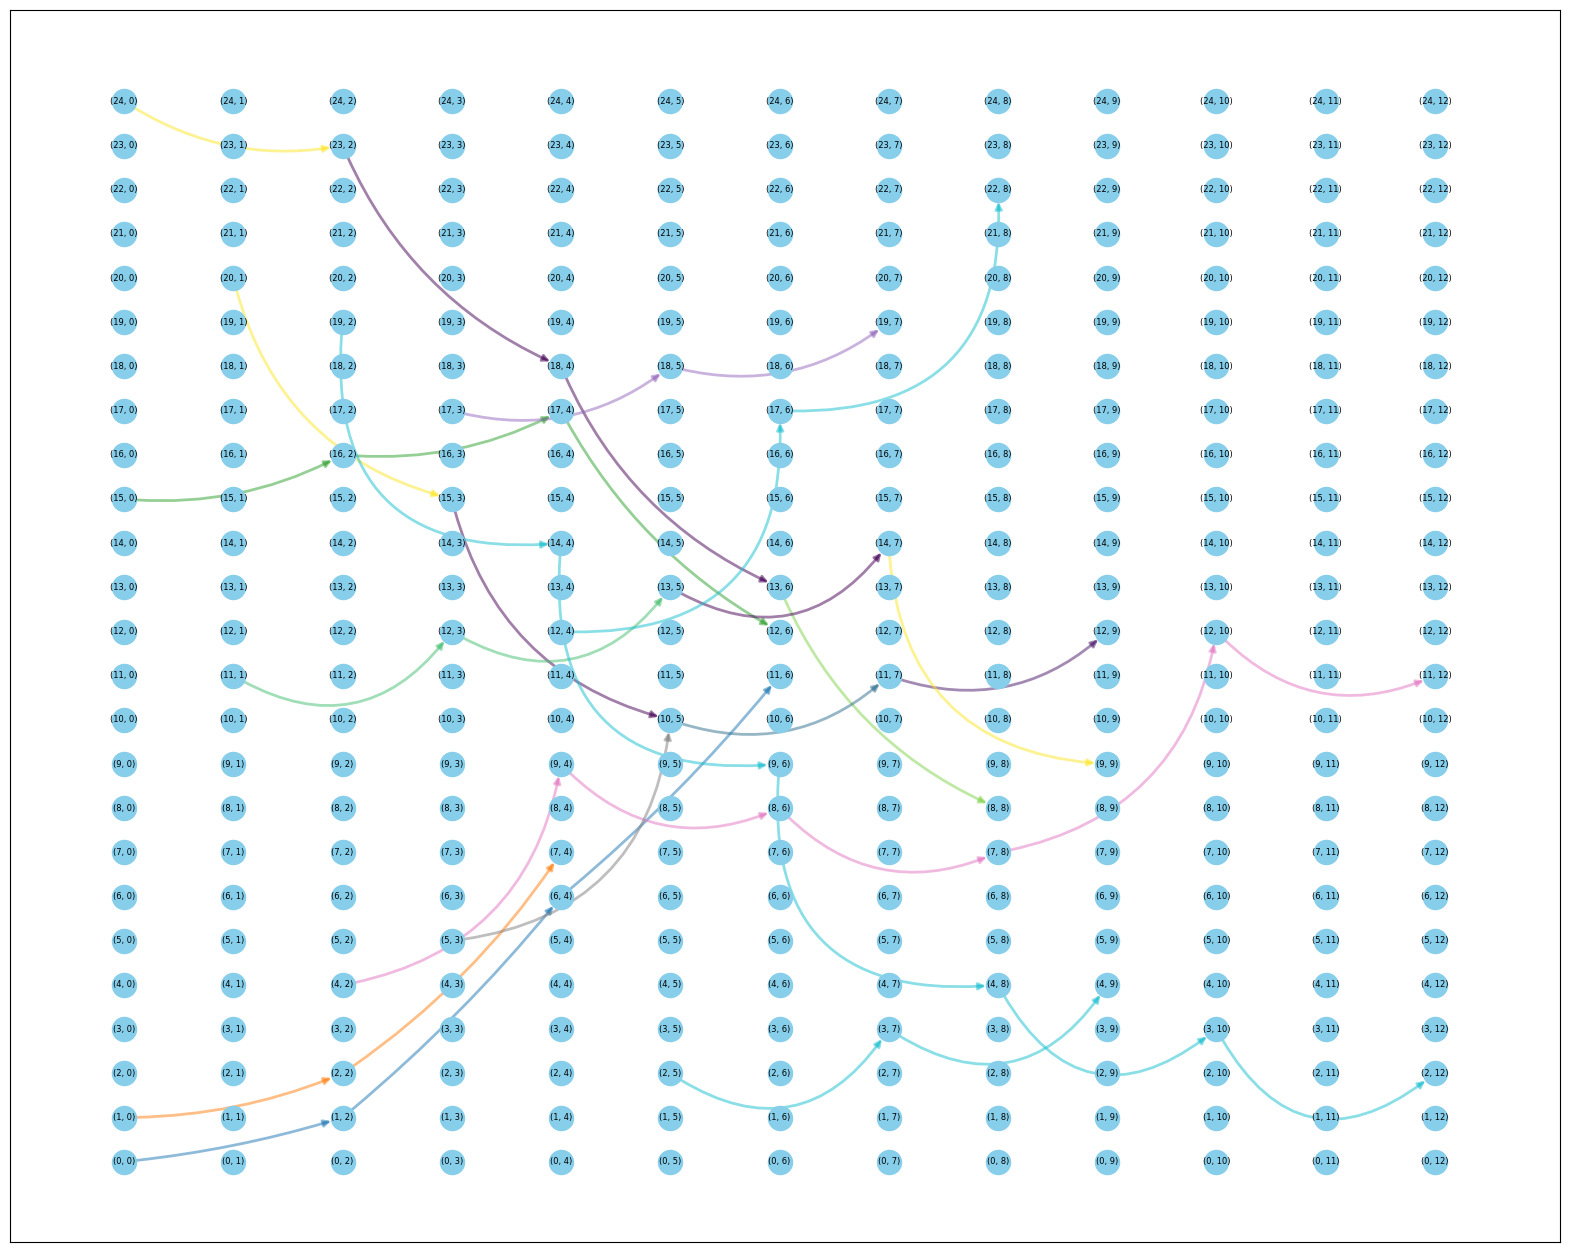

In [14]:
fig, ax = plt.subplots(figsize=(20, 16))
#nx.draw(G, pos=pos, with_labels=True, node_size=300, node_color="skyblue",ax=ax,edge_color=edge_color_list)
nx.draw_networkx_nodes(G, pos,node_size=300,node_color="skyblue",ax=ax)

#for i in range(number_vehicle):
for i in draw_k:
    nx.draw_networkx_edges(G, pos,connectionstyle=f'arc3, rad = {0.05*(i+1)}', edgelist = arc_all[f'{i}'], width = 2, alpha = 0.5, edge_color=color_list[i])
    #nx.draw_networkx_edges(G, pos,connectionstyle='arc3, rad = 0.1', edgelist = arc_all['1'], width = 2, alpha = 0.5, edge_color='r')
    #nx.draw_networkx_edges(G, pos,connectionstyle='arc3, rad = 0.2', edgelist = arc_all['2'], width = 2, alpha = 0.5, edge_color='g')


ll = nx.draw_networkx_labels(G, pos, labels={node: node for node in G.nodes()}, font_size=6)


'''
0 1 2
3 4 5
6 7 8
'''
start = [(0,0),(2,1),(0,2)]
dest = [2,0,7]

In [15]:
l[(1,2),(2,4)]

<gurobi.Var number_of_b_(1, 2)&(2, 4) (value 0.0)>

In [15]:
for z in Z.keys():
    if Z[z].x >0:
        print(z)

((2, 4), 1)
((2, 5), 0)
((7, 2), 2)
